In [2]:
import numpy
import cv2
from PIL import Image
from IPython.display import display
import matplotlib.pyplot as plt
from scipy import ndimage
print("OpenCV-Python Version {}".format(cv2.__version__))
print("Расчет статистик по изображению. Яркость, Контраст, Сумма RGB.")

#sizes
def imgSizeFromPath(path):
  sArr = path.split("_")
  imsize = (2592,1944)
  for s in sArr:
    if(s.find("x") != -1):
      sizeArr = s.split("x")
      w = 1
      h = 1
      if(sizeArr[0].isdigit() & sizeArr[1].isdigit()):
        w = int(sizeArr[0])
        h = int(sizeArr[1])
      else: continue
      imsize = (w,h)
  return imsize

#resorting colours
def splitBayer(arr):
    R  = arr[0::2, 0::2]
    Gr = arr[0::2, 1::2]
    Gb = arr[1::2, 0::2]
    B  = arr[1::2, 1::2]
    return numpy.dstack((R,Gr,Gb,B))

def combineBayer(stack):
    R = stack[...,0]
    height, width = R.shape
    bayer_im = numpy.zeros((height*2, width*2), dtype=R.dtype)
    bayer_im[0::2, 0::2] = R
    bayer_im[0::2, 1::2] = stack[...,1]
    bayer_im[1::2, 0::2] = stack[...,2]
    bayer_im[1::2, 1::2] = stack[...,3]
    return bayer_im

#open img
def readToArray(path, rows, cols, depth = numpy.uint16, blevel = 800):
    with open(path, "rb") as f:
      a = numpy.fromfile(f,depth,rows*cols).reshape(rows,cols)-blevel
      a <<= 2 #bit depth = 14
      return a

#show img
def imshow(arr):
    """Только uint16"""
    scale = 0.3
    image = Image.fromarray((arr/256).astype(numpy.uint8))
    image.resize((( int(image.width * scale), int(image.height * scale))))
    display(image)

def graph(arr, name = ""):
  """x = horizontal = value"""
  """y = vertical = number"""
  unique, counts = numpy.unique(arr, return_counts=True)
  plt.plot(unique, counts)
  plt.xlabel('значение') #Подпись для оси х
  plt.ylabel('количество') #Подпись для оси y
  plt.title(name) #Название
  plt.show()

#pic to tiles
def reshape_split(image: numpy.ndarray, kernel_size: tuple):
    """https://towardsdatascience.com/efficiently-splitting-an-image-into-tiles-in-python-using-numpy-d1bf0dd7b6f7"""
    img_height, img_width, channels = image.shape
    tile_height, tile_width = kernel_size

    tiled_array = image.reshape(img_height // tile_height,
                                tile_height,
                                img_width // tile_width,
                                tile_width,
                                channels)
    tiled_array = tiled_array.swapaxes(1, 2)
    return tiled_array

OpenCV-Python Version 4.8.0
Расчет статистик по изображению. Яркость, Контраст, Сумма RGB.


In [10]:
#base
#name_M = "/content/drive/MyDrive/Colab Notebooks/lab second/macbeth_2592x1944_RG.raw"
#name_M = "/content/drive/MyDrive/Colab Notebooks/lab second/lsc_1920x1096_RG.raw"
name_M = "/content/drive/MyDrive/Colab Notebooks/lab second/sfr.2592x1944p5184b14.raw"
imgSize = (2592,1944) #imgSizeFromPath(name_M)
h, w = imgSize
depth = numpy.uint16

#open
image_M = readToArray(name_M, w, h, depth)
img_split_M = splitBayer(image_M)

img_RGB = cv2.cvtColor(combineBayer(img_split_M), cv2.COLOR_BayerRGGB2RGB)
imshow(img_RGB)

#statistics
color = ('r','gr', 'gb','b')
nn = 1

for i,col in enumerate(color):
    #plt.subplot(1, 4, nn)
    plt.hist(numpy.array(img_split_M[...,i]).ravel(),bins = 100)
    plt.title(col)
    nn+=1
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [4]:
print(img_split_M.shape)
center_x, center_y  = numpy.array(img_split_M[...,0].shape)//2
center_brightness = img_split_M[center_x][center_y]
print(center_brightness)

#4 на 3 2592x1944 ?
# 1920x1096 16 to 10
#max 32 tiles
def primfacs(n):
   i = 2
   primfac = []
   while i * i <= n:
       while n % i == 0:
           primfac.append(i)
           n = n // i
       i = i + 1
   if n > 1:
       primfac.append(n)
   return primfac

def tileSize(a, maxtiles=32):
  a_p = primfacs(a)
  #print('{} = {}' .format(a, a_p))
  a_t = 1
  for i in a_p:
    if a_t*i <= maxtiles:
      a_t *= i
    else:
      break
  #print(maxtiles, a_t)
  return a_t
# a, b, _ = img_split_M.shape
# a = a//tileSize(a)
# b = b//tileSize(b)

a, b, _ = img_split_M.shape
a=a//(18)
b=b//(27)
print(a, b)

(972, 1296, 4)
[4032 6400 6912 3776]
54 48


In [7]:
resh = reshape_split(img_split_M, (a, b))
means = numpy.mean(resh,axis=(2,3))
print(means.shape)
means = numpy.mean(means,axis=(2)).astype(depth)

imshow(img_RGB)

import pandas as pd
from IPython.display import HTML
table = pd.DataFrame(means)
display(HTML(table.to_html())) #lightness

Output hidden; open in https://colab.research.google.com to view.

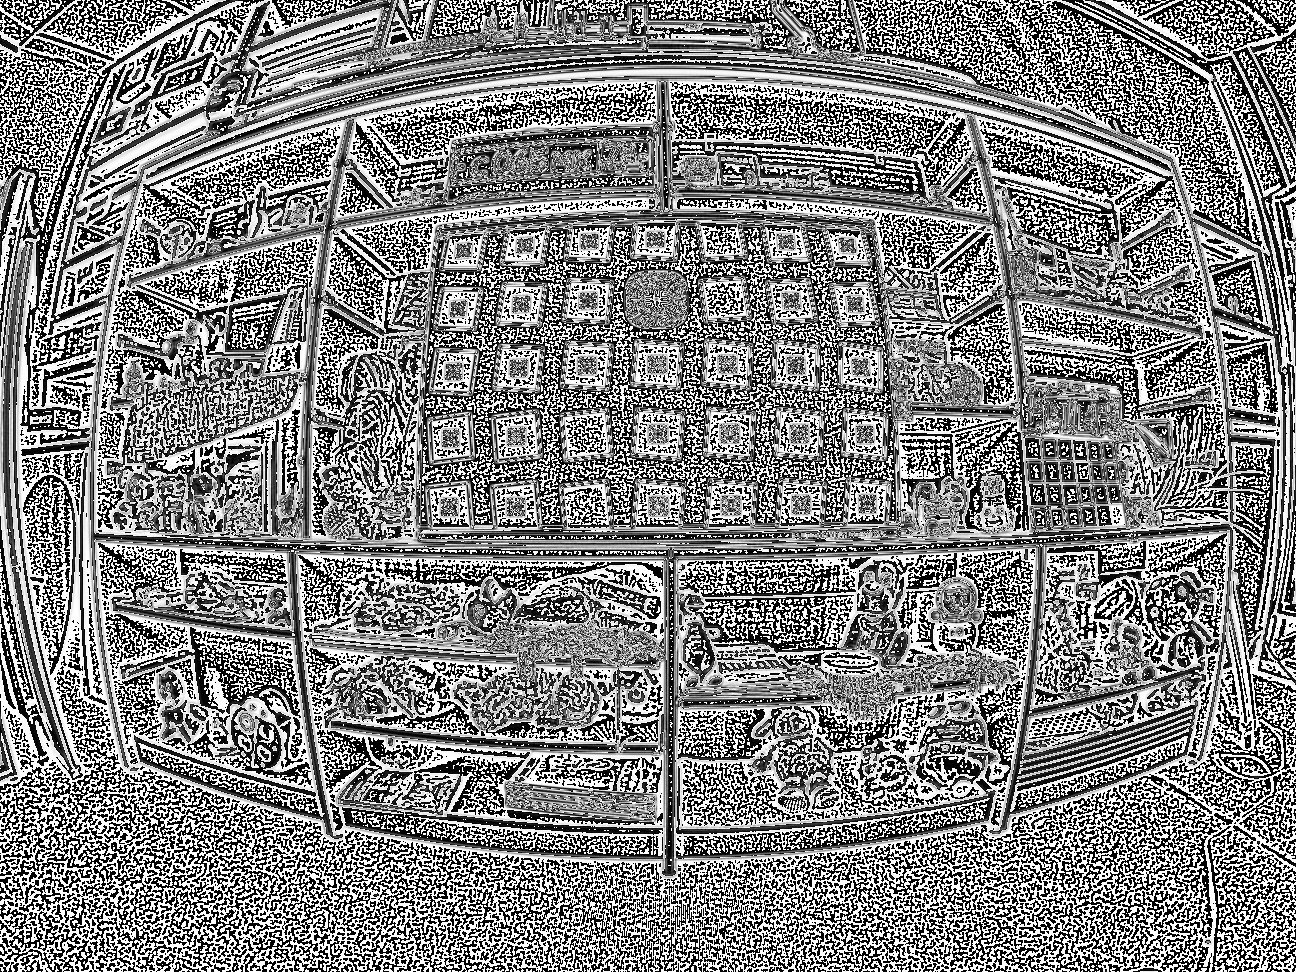

(18, 27)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26
0,30747,31469,33046,35222,37306,33550,36032,35697,32759,29449,31094,29870,30367,29429,32695,30452,31146,30219,30407,32609,31954,31299,29973,31979,32344,30356,30834
1,31783,34248,35076,31743,32153,34703,39236,32198,34463,36236,36149,34907,35749,34766,35716,36716,37295,37217,37247,35242,32278,34067,31719,31630,31459,31028,29051
2,32486,33339,37401,41770,35664,37769,35537,37700,34225,32562,28421,30915,29706,30670,31991,31875,32294,31907,30915,31528,36973,35507,37103,33599,32318,34425,28949
3,32765,33771,40043,35287,32996,32040,33213,33596,31843,30258,31911,33955,33721,31735,31834,31590,35034,32774,28762,30896,34240,33878,31988,34364,35786,31671,33184
4,31814,34314,36550,33794,31588,35529,34719,33036,34323,37534,32905,31048,33107,32322,31853,30173,33055,33331,33182,32501,32822,31358,31516,31409,35338,33114,31875
5,35050,34732,35903,33122,32453,31599,32932,31225,32887,33761,33975,33054,34467,31261,30680,32048,34743,33576,33840,33737,32989,33572,32549,32693,32531,30834,31582
6,34286,31939,36861,31491,32631,32532,34844,31329,31071,33832,32155,31900,33685,33943,32636,33369,34466,32267,35196,35237,33149,35225,34461,31698,31589,34498,32297
7,33984,35662,35902,34723,33439,36004,33899,31017,31441,34086,32591,32324,33151,33506,32194,32923,34118,32542,32509,32001,31701,31796,30951,32771,30238,33573,33530
8,36097,31952,36610,34335,33264,35722,33274,32591,33842,32478,31449,31841,31732,32739,31667,32019,32975,31469,33826,32886,31303,26648,29294,35341,33273,31809,33630
9,35724,35809,33780,32699,32827,34364,32316,32890,33650,35781,33230,30145,32174,33460,31573,32805,34038,33571,34916,36018,34388,27310,24913,33223,33960,32078,31595


In [6]:
from scipy import ndimage
kernel = numpy.array([[-1, -1, -1, -1, -1],
                   [-1,  1,  2,  1, -1],
                   [-1,  2,  4,  2, -1],
                   [-1,  1,  2,  1, -1],
                   [-1, -1, -1, -1, -1]])
# kernel = numpy.array([[-1, -1, -1],
#                    [-1,  8, -1],
#                    [-1, -1, -1]])
img_k = numpy.mean(img_split_M,axis=(2)).astype(depth)
highpass_5x5 = ndimage.convolve(img_k, kernel)
imshow(highpass_5x5)

#pic to tiles
def reshape_split_2c(image: numpy.ndarray, kernel_size: tuple):
    """https://towardsdatascience.com/efficiently-splitting-an-image-into-tiles-in-python-using-numpy-d1bf0dd7b6f7"""
    img_height, img_width = image.shape
    tile_height, tile_width = kernel_size

    tiled_array = image.reshape(img_height // tile_height,
                                tile_height,
                                img_width // tile_width,
                                tile_width)
    tiled_array = tiled_array.swapaxes(1, 2)
    return tiled_array

reshk = reshape_split_2c(highpass_5x5, (a, b))
meansk = numpy.mean(reshk,axis=(2,3)).astype(depth)
print(meansk.shape)
#meansk = numpy.mean(meansk,axis=(2)).astype(depth)
imshow(meansk)
table = pd.DataFrame(meansk)
display(HTML(table.to_html())) #lightness